In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# A problem of simulation

If we want to simulate a set of random points from a uniform or normal distributions, we have built in methods to do that directly by using `np.random.random` or `np.random.normal`

In [2]:
uniform_points = np.random.random(size=2000)
normal_points = np.random.normal(size=2000)

Text(0.5,1,'Normal Distribution')

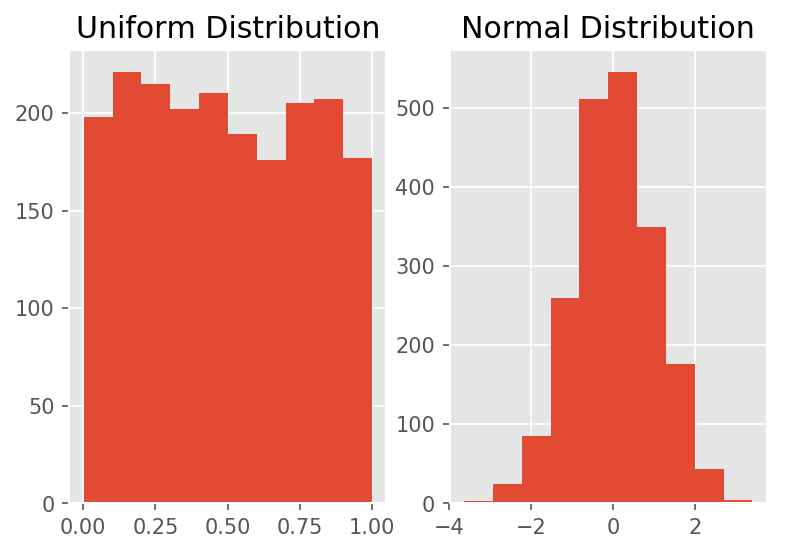

In [3]:
# Make two plots of our generated points
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(uniform_points)
ax1.set_title('Uniform Distribution')

ax2.hist(normal_points)
ax2.set_title('Normal Distribution')

Our goal is to generate an exponential distribution, or other 'non-standard' distribution.


It turns out we can do this using `numpy.random.exponential` which is built in, but there are lots of other custom distributions that don't have random number generators built-in. We will show two ways of using the _uniform_ random number generator to get numbers for other distributions.

Our first approach is mathematical, and only works for relatively simple distributions. The probability density function for the exponential distribution is
$$p(x) = \frac{1}{\lambda} \exp(-\lambda x), \quad\quad (x\text{ greater than 0})$$
where $\lambda$ is a parameter the controls the "rate" that the distribution decays. We can sum (or integrate) probabililities to find the _cumulative distribution function_ (cdf). The idea is that $cdf(x)$ tells us the probability of a randomly selected number being less than or equal to $x$. It is the same idea as finding the percentile. For example, if $cdf(3) = 0.8$, this means that 80% of the time randomly drawn numbers are less than 3, or in a large sample of randomly drawn numbers that 3 would be the 80th percentile. 

We will be interested in the inverse cumulative distribution, $cdf^{-1}$. This is a function that takes the probability $p$, and tells us what the $p$-th percentile is. In our previous example, $cdf^{-1}(0.8) = 3$, because 3 is the 80th percentile of the distribution.

For the exponential distribution, we can find the CDF by integrating:
$$cdf(x) = P(X \leq x) = \int_0^\infty p(x^\prime)\,\d x^\prime = (1 - \exp(-\lambda x))$$
Then we need to do a little algebra to find the inverse CDF:
$$cdf^{-1}(x) = - \frac{1}{\lambda} \ln(1 - x)$$

Why is this useful? We make the following plan to get numbers from the exponential distribution:
1. Draw a number uniformly from 0 to 1. Let's say we get $r = 0.8$.
2. Use the inverse cdf to find which number $x$ has $cdf(x) = r$. For example, in our example distribution, $cdf^{-1}(0.8) = 3$.
3. Use the number found in step 2 as our sample.

Why does this work? The uniform distribution from 0 to 1 generates numbers less than 0.8 80% of the time. Then step 2 guarantees that we are getting numbers less than 3 80% of the time. This doesn't just work for 0.8 -- it works for all the percentiles. Let's see this in action:

CPU times: user 50.2 ms, sys: 2.77 ms, total: 53 ms
Wall time: 53.6 ms


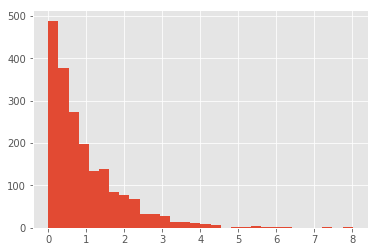

In [4]:
%%time
def inv_cdf(p, lambda_):
    return -1.0/lambda_ * np.log(1 - p)

sample = [inv_cdf(p, 1.0) for p in uniform_points]

plt.hist(sample, bins=30);

Note this function is also ready to be vectorized, because it uses numpy's version of log:

CPU times: user 58 ms, sys: 12.8 ms, total: 70.7 ms
Wall time: 68.8 ms


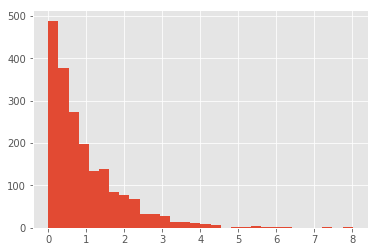

In [5]:
%%time
sample = inv_cdf(uniform_points, 1.0)
plt.hist(sample, bins=30);

The steps for this technique were:
1. Integrate the probability density function $p(x)$ to get the CDF. (Calculus)
2. Invert the CDF (algebra) to get $cdf^{-1}$.
3. Feed $cdf^{-1}$ a random sample of uniformly distributed points from 0 to 1. The output will be a random sample from your original distribution.

Steps 1 and 2 can be very difficult for general distributions. For example, the normal distribution can only be integrated numerically! Even when the integral can be done, often the resulting CDF can only be inverted numerically.

We will show a technique called Monte Carlo that can be applied to a broad range of distributions

## Technique 2: Monte Carlo Markov Chains

The idea here is that we will go through a two step process:
1. Based on the current sample $x_i$, use a random process to draw a proposed new point $y$
2. Then choose your next point $x_{i+1}$ to either be your proposed point $y$, or $x_{i}$ again

We will pick our "proposed point" $y$ in the following way:
$$y = \text{abs}(x_i + \text{normal}(0,\sigma))$$
This ensures that our proposed point is always non-negative. 

Our accept / reject procedure is 
$$\text{prob accept} = P(y)/P(x_i) = \exp(\lambda(x-y))$$
Let's see it in action, then discuss why it works

In [6]:
def new_sample(old_point, lambda_ = 1):
    # this generates the proposed point
    y = abs(old_point + np.random.normal(loc=0, scale=0.3))
    
    # Accept the point with probability P(y)/P(x)
    # First calculate the probability 
    p = np.exp(lambda_*(old_point - y))
    
    # Choose whether to repeat the same point, or keep the new
    # point
    if (np.random.random() < p):
        return y
    return old_point

samples = [10]
while len(samples) < 5000:
    new_point = new_sample(samples[-1])
    samples.append(new_point)
    

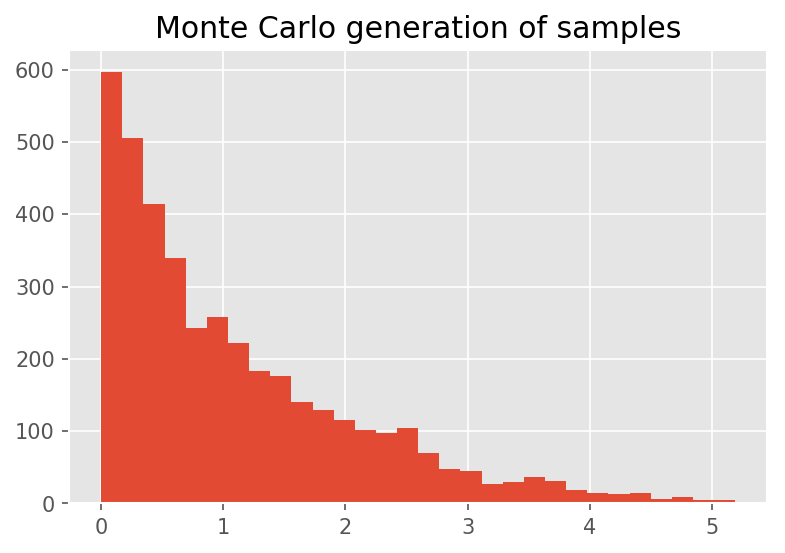

In [7]:
# Let's visualize, cutting off the first 1000 
plt.figure(dpi=150)
plt.title('Monte Carlo generation of samples')
plt.hist(samples[1000:], bins=30);

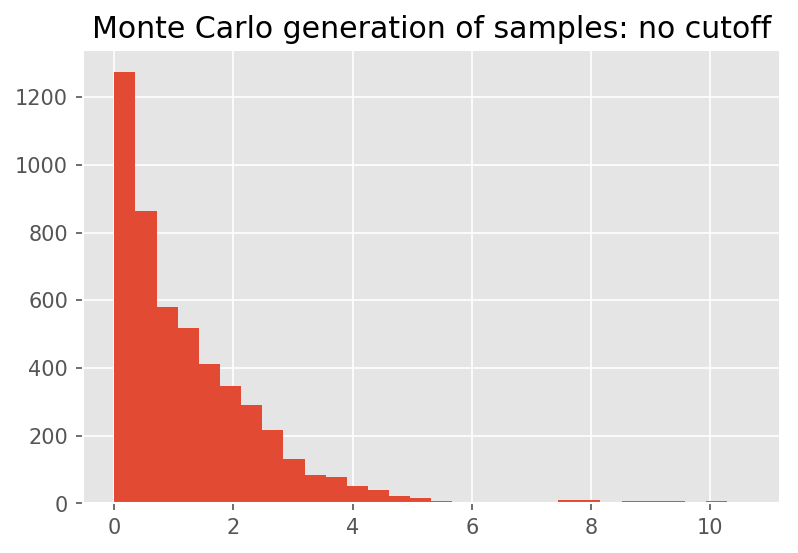

In [8]:
# Let's visualize, cutting off the first 1000 
plt.figure(dpi=150)
plt.title('Monte Carlo generation of samples: no cutoff')
plt.hist(samples, bins=30);

So the nice things about this Monte-Carlo approach are
- we didn't need to do any integrations or algebra
- the approach is flexible to many different distributions

The downsides are:
- We had to throw away some of our data while our simulatoin learned the distribution
- We need to generate the data in order, so we have to do it sequentially rather than in parallel
- There are hyperparameters to choose, such as the width of the "update" size, that have to be tuned
- Once done, there are correlations between neighboring samples. If you are simulating a sample, you should shuffle and select a subsample.

Let's discuss why this procedure works:

Text(0.5,0,'sample number')

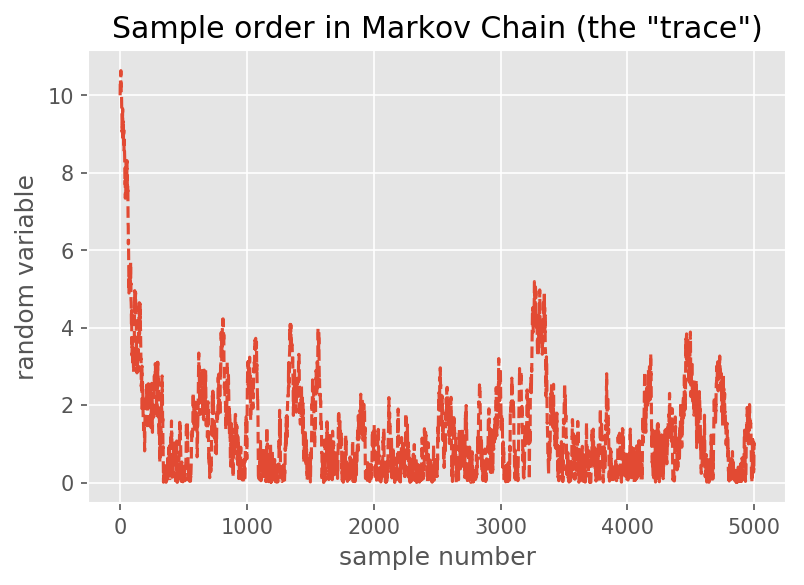

In [9]:
plt.figure(dpi=150)
plt.plot(range(len(samples)), samples, '--')
plt.title('Sample order in Markov Chain (the "trace")')
plt.ylabel('random variable')
plt.xlabel('sample number')

In [10]:
from pandas.plotting import autocorrelation_plot

(0, 500)

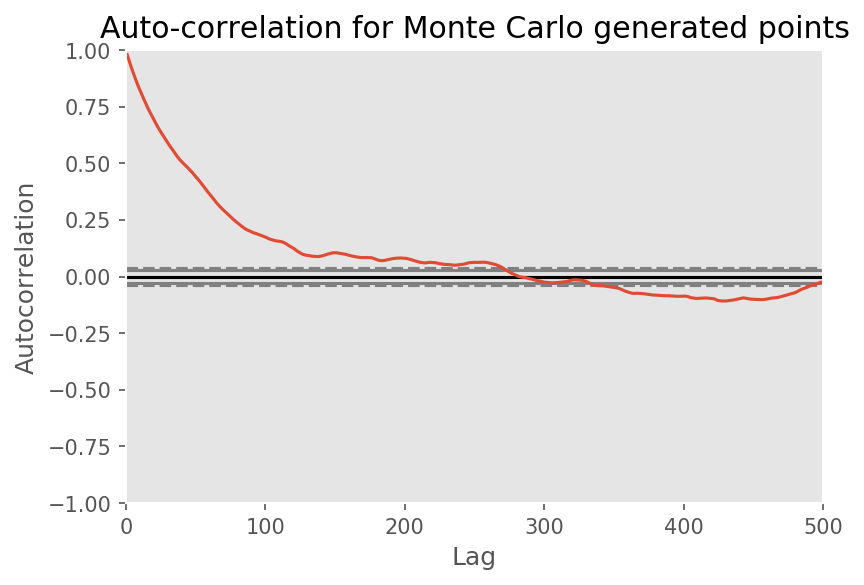

In [11]:
plt.figure(dpi=150)
autocorrelation_plot(samples)
plt.title('Auto-correlation for Monte Carlo generated points')
plt.xlim(0,500)

(0, 500)

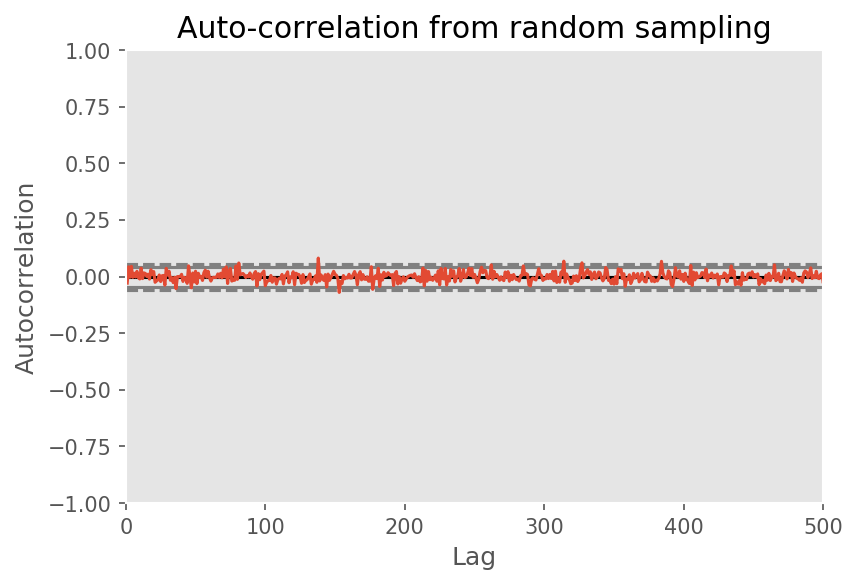

In [12]:
# Use our mathematical method for getting drawing points at random every time
sample_math_method = inv_cdf(uniform_points, 1.0)

plt.figure(dpi=150)
autocorrelation_plot(sample_math_method)
plt.title('Auto-correlation from random sampling')

plt.xlim(0,500)